In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import transforms, models
from torchinfo import summary
import os
from glob import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mlflow
import cv2
from tqdm import tqdm

In [9]:
train_info = {
    'exp_name': 'face_mask',
    'batchSize': 32,
    'img_shape': [3,224,224],
    'epoch': 20,
    'early_stop': 2,
    'lr': 0.0001,
    'optim': 'Adam',
    'secheduler': 'CosineAnnealingLR',
    'loss': 'CrossEntropyLoss'
}


In [3]:
class MaskDataset(Dataset):
    
    def __init__(self, path, num_classes=2):
        mask = glob(path+'WithMask/*.png') # finds all the files matching the pattern , i.e., mask files
        nomask = glob(path+'WithoutMask/*.png') # finds all the files matching the pattern , i.e., non-mask files
        
        self.num_clsses = num_classes
        self.fpath = mask+nomask  # combining all the files 
        self.transform = transforms.Compose([
                            transforms.ToPILImage(),                    
                            transforms.Resize((224,224)),
                            transforms.ToTensor(),
                            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                 std=[0.229, 0.224, 0.225])])
        self.target = ['WithMask' in fpath.split('/')[-2] for fpath in self.fpath] # getting labels out of the folder name
                                                                                   # mask : 1, nomask : 0 
        
    def __len__(self):
        return len(self.fpath) 
    
    def __getitem__(self, idx):
        img_path = self.fpath[idx]
        img = (cv2.imread(img_path)[:,:,::-1]) # converting the images to numpy array 
        img = self.transform(img)
        
        tgt = self.target[idx]
        tgt = torch.tensor(tgt, dtype=torch.long)
        return img.float(), tgt

In [4]:
# data path
train_path = './face_12k_data/Face Mask Dataset/Train/'
val_path = './face_12k_data/Face Mask Dataset/Validation/'
test_path = './face_12k_data/Face Mask Dataset/Test/'


# Defining train data, validation data, test data
train_data = MaskDataset(train_path)
val_data = MaskDataset(val_path)
test_data = MaskDataset(test_path)

# Dataloader for train, validation, test with batch size 32
train_loader = DataLoader(train_data, batch_size=train_info['batchSize'], shuffle=True, num_workers=0) 
val_loader = DataLoader(val_data, batch_size=train_info['batchSize'], shuffle=True, num_workers=0) 
test_loader = DataLoader(test_data, batch_size=train_info['batchSize'], shuffle=False, num_workers=0) 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([224, 224, 3])
tensor(1)


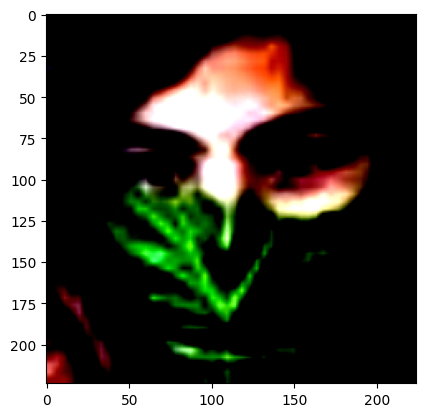

In [5]:
# Looking at one image in training data
im, label = train_data[400]
plt.imshow(im.permute(1,2,0).cpu())
print(im.permute(1,2,0).cpu().size())
print(label)

In [10]:
images, labels = next(iter(train_loader)) 

print("Number of elements in this batch", len(labels))
print("Image size (batch, channel, height, width):", images.shape)
print("Label length:", labels.shape)

Number of elements in this batch 32
Image size (batch, channel, height, width): torch.Size([32, 3, 224, 224])
Label length: torch.Size([32])


In [11]:
# get pretrained vgg19 model
def get_face_vgg19():
    model = models.vgg19(pretrained=True)
    for param in model.parameters():
        param.requires_grad = False
    # 取得vgg19的特徵提取部分
    features = list(model.classifier.children())[:-1] # 移除最後的全連接層
    
    # 添加一些全連接層
    features.extend([
        nn.Linear(4096, 1024),
        nn.ReLU(True),
        nn.Dropout(p=0.5),
        nn.Linear(1024, 256), 
        nn.ReLU(True),
        nn.Dropout(p=0.5),
        nn.Linear(256, 2),
        nn.Sigmoid()
    ])
    
    # 替換原始的classifier
    model.classifier = nn.Sequential(*features)
    return model


In [12]:
#check cuda
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device,'is available!\n')
model = get_face_vgg19()
model = model.to(device)
model_info = summary(model, (32, 3,224,224))
with open("model_info.txt", "w") as f:
    f.write(model_info.__repr__())

cuda:0 is available!



Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /home/jovyan/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:53<00:00, 10.8MB/s] 


In [13]:
# Loss optimizer setting

optimizer = optim.Adam(model.parameters(),betas=(0.9, 0.98), lr=train_info['lr'])
scheduler=lr_scheduler.CosineAnnealingLR(optimizer,10)
criterion= nn.CrossEntropyLoss()

In [14]:
# Training
#store loss inf
#loss={'train_loss':[],'valid_loss':[],'lr':[]}        

#early_stopping
patience= train_info['early_stop']
earlystop=0
best_loss=float('inf')

# mlflow set url
mlflow.set_tracking_uri("http://mlflow-web:5000/")

if not mlflow.get_experiment_by_name(train_info['exp_name']):
    mlflow.create_experiment(train_info['exp_name'])

mlflow.set_experiment(train_info['exp_name'])

with mlflow.start_run() as run:
    # para
    mlflow.log_param("data set", "Face Mask Detection ~12K Images Dataset - Kaggle")
    mlflow.log_param("Batch Size", train_info['batchSize'])
    if device != 'cpu':
        mlflow.log_param("gpu", "enabled")
    mlflow.log_param("epoch",train_info['epoch'])
    mlflow.log_param("optimizer", train_info['optim'])
    mlflow.log_param("init_lr", train_info['lr'])
    mlflow.log_param("scheduler", train_info['secheduler'])
    mlflow.log_param("loss function", train_info['loss'])
    mlflow.log_artifact("model_info.txt")

    for epoch in range(20):
        #model train
        model.train()
        steps_loss=[]
        with tqdm(train_loader,leave=False) as tepoch:
            for inputs, target in tepoch:
                #set tqdm description
                tepoch.set_description(f'TrainEpoch{epoch+1:3d}')
                inputs, target=inputs.to(device), target.to(device)
                # Zero the parameter gradients
                optimizer.zero_grad()
                output = model(inputs)
                crit = criterion(output, target)
    
                steps_loss.append(crit.cpu().item())
    
                crit.backward()
                optimizer.step()
                tepoch.set_postfix({'loss':'{0:.3f}'.format(np.average(steps_loss))})
    
        scheduler.step()
        #loss['train_loss'].append(np.average(steps_loss))
        mlflow.log_metric("train_loss", np.average(steps_loss), epoch+1)
        
        #model valid
        model.eval()
        steps_loss=[]
        with tqdm(val_loader,leave=False) as vepoch:
            for inputs, target in vepoch:
                vepoch.set_description(f'ValidEpoch{epoch+1:3d}')
                inputs,target=inputs.to(device), target.to(device)
    
                output=model(inputs)
                crit=criterion(output,target)
    
                steps_loss.append(crit.cpu().item())
                vepoch.set_postfix({'loss':'{0:.3f}'.format(np.average(steps_loss))})
    
        #loss['valid_loss'].append(np.average(steps_loss))
        #loss['lr'].append(scheduler.get_last_lr())
        mlflow.log_metric("valid_loss", np.average(steps_loss), epoch+1)
        mlflow.log_metric("learning_rate", scheduler.get_last_lr()[0], epoch+1)

        
        # earlystopping
        cur_loss=np.average(steps_loss)
        if cur_loss>best_loss:
            earlystop+=1
            if earlystop>= patience:
                print('Early stopping!')
                mlflow.log_param("Early_Stopping_Happened", f'finish in {epoch+1} epochs!' )
                break
        else:
            earlystop=0
            best_loss=cur_loss
        mlflow.log_metric("early stop count", earlystop, epoch+1)

    print('Finished Training')

    #Start testing
    test_acc={}
    classes = ['No Mask', 'Mask']
    # Test
    correct = 0
    total = 0
    
    model.eval()
    with tqdm(test_loader,leave=True) as tepoch:
        for inputs, labels in tepoch:
            inputs, labels= inputs.to(device), labels.to(device)
            output=model(inputs)
            _, predicted = torch.max(output,1)
            total+=labels.size(0)
            correct += (predicted == labels).sum().item()
            c=(predicted==labels).squeeze()
    
            for i in range(labels.size(0)):
                label=labels[i].item()
                if label not in test_acc:
                    test_acc[label]=[0,0]
                else:
                    test_acc[label][0]+=c[i].item()
                    test_acc[label][1]+=1
    
    
    
    
    for i in range(len(classes)):
        print('Accuracy of %10s : %2d %%' % (classes[i], 100 * test_acc[i][0] / test_acc[i][1]))
    print()
    print('Test Dataset : %d %%' % (100 * correct / total))
    mlflow.log_metric("test accuracy", (100 * correct / total))
    #tmp = torch.jit.script(model)
    #mlflow.pytorch.log_model(model, "pytorch-model", registered_model_name="test")

Early stopping!
Finished Training


100%|██████████| 31/31 [00:05<00:00,  5.44it/s]

Accuracy of    No Mask : 100 %
Accuracy of       Mask : 100 %

Test Dataset : 100 %


In [15]:
# load pytroch model
#summary()
model.eval()
scripted_model = torch.jit.script(model, torch.randn(1,3,224,224).to(device))
torch.jit.save(scripted_model, "model.pt")

/usr/local/lib/python3.8/dist-packages/torch/jit/_script.py:1241: UserWarning: `optimize` is deprecated and has no effect. Use `with torch.jit.optimized_execution() instead
  warnings.warn(
